In [1]:
import numpy as np
import scipy.ndimage as snd

import MotionClouds as mc
import matplotlib.pyplot as plt

from tqdm import tqdm
import itertools

import imageio, imageio.core.util
import warnings
from psychopy import visual, core, event

import shutil
import os

import time

from math import atan2, degrees

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Main stimulation notebook,
# Last update : June 2020 (minor, also used in M experiments, January 2020)
# Ctrl + Shift + Enter to run all

## Parameters

In [2]:
# --------------------------------------
#  Insertion specific parameters, change
# --------------------------------------

# Insertion name
exp_name = 'AM001'

# --------------------------------------
#  Constant parameters, do not change
# --------------------------------------
# Number of repetition for each pattern 
repetition = 15

# Spatial frequency, in cpd
sf = np.array([.9]) / 2 # 2 3 

# Orientations
N_thetas = 12
thetas = np.linspace(0, np.pi, N_thetas, endpoint = False)

# Precisions
N_Bthetas = 8
B_thetas = np.linspace(np.pi/2, 0, N_Bthetas)/ 2.5

# Phases this parameter is not actually used but stays in the code to regenerate sequence
# Also they're actually a direction
N_phases = 2
phases = np.linspace(0, .05, N_phases, endpoint = False)
# This one is used to increment the phase at each flip. 
# Given 1 phase = 80 degrees, and there is stim_duration / .16 frames available, you get
phase_increment = .002

# Duration of each pattern
stim_duration = .29 # s, using just a little bit less than the actual duration permits accurate timing
#stim_duration = .14  
inter_duration = .15
# Number of each pattern repetitions


# RNG
seed = 42

# MotionClouds parameters
downscale = 1
N_X, N_Y, N_frames = 512, 512, 1

sf_0 = sf
B_sf = sf_0

# Screen parameters
screen_units = 'pix' # of visual angle, @ 57 cm dist 1 cm approx 1 deg
screen_X = 1920
screen_Y = 1080 # doesnt affect the screen, affect the Sf scaling
screen_dist = 57 # cm, screen distance 
screen_height = 80 #cm

# whether print statements for the runs are done
verbose = False

## Init

In [3]:
# Subject name
exp_date = '_07072020'
exp_name+= exp_date

In [4]:
if screen_units == 'pix':
    deg_per_px = degrees(atan2(.5*screen_height, screen_dist)) / (.5*screen_Y)
    cpd_per_px = 1/deg_per_px
    sf = sf/cpd_per_px
    sf *= (screen_Y / N_Y) 
    
    # Change for MC too
    sf_0 = sf
    B_sf = sf
    
    print('One degree is %s pixels' % deg_per_px)
    print('It takes %s px for 1 cycle' % cpd_per_px)
    print('So to get 1 cpd, we need param of value %s' % sf)

One degree is 0.0649248647534944 pixels
It takes 15.402419455116043 px for 1 cycle
So to get 1 cpd, we need param of value [0.0616279]


In [5]:
# MC 
fx, fy, ft = mc.get_grids(N_X//downscale, N_Y //
                          downscale, mc.N_frame//downscale)

# RNG
np.random.seed(seed)

MC_sequence = list(itertools.product(thetas, B_thetas, phases))
np.random.shuffle(MC_sequence)

# Folder
mc.figpath = os.path.join('./backup/%s' % exp_name)
if not(os.path.isdir(mc.figpath)):
    os.mkdir(mc.figpath)

## Sanity visualisation

Total time : [21.12] minutes
Block time : [15] blocks of [55.67999999999999]s, each pattern for [0.29]s
---
MC : [12] thetas and [8] b_thetas
Thetas : [0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327] 
Bthetas : [0.62831853 0.53855874 0.44879895 0.35903916 0.26927937 0.17951958
 0.08975979 0.        ]
---
Phases : [2] phases
Phases : [0.    0.025]


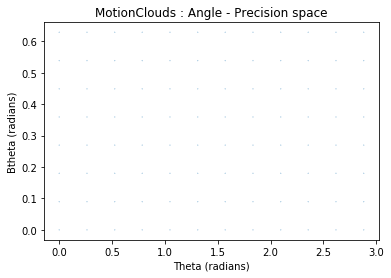

In [6]:
print('Total time : [%.2f] minutes' %
      ( (((len(MC_sequence)*stim_duration*repetition) + (len(MC_sequence) * inter_duration * repetition)) /60)))
print('Block time : [%s] blocks of [%s]s, each pattern for [%s]s' % (
    repetition, stim_duration*len(MC_sequence), stim_duration))
print('---')
print('MC : [%s] thetas and [%s] b_thetas' % (N_thetas, len(B_thetas)))
print('Thetas :', thetas, '\nBthetas :', B_thetas)
print('---')
print('Phases : [%s] phases' % (N_phases))
print('Phases :', phases)

plt.scatter(*zip(*MC_sequence))
plt.xlabel('Theta (radians)')
plt.ylabel('Btheta (radians)')
plt.title('MotionClouds : Angle - Precision space')
plt.show()

## Functions

In [7]:
def silence_imageio_warning(*args, **kwargs):
    pass

imageio.core.util._precision_warn = silence_imageio_warning

def get_keypress():
    keys = event.getKeys()
    if keys:
        return keys[0]
    else:
        return None

def generate_cloud(theta, b_theta, phase,
                   N_X, N_Y, seed, contrast=1.,
                   transition=False):

    fx, fy, ft = mc.get_grids(N_X, N_Y, 1)
    
    disk = mc.frequency_radius(fx, fy, ft) < .5
    
    if b_theta == 0 : 
        mc_i = mc.envelope_gabor(fx, fy, ft,
                                 V_X=0., V_Y=0., B_V=0.,
                                 sf_0=sf_0, B_sf=B_sf,
                                 theta=0, B_theta=b_theta)
    else : 
        mc_i = mc.envelope_gabor(fx, fy, ft,
                                 V_X=0., V_Y=0., B_V=0.,
                                 sf_0=sf_0, B_sf=B_sf,
                                 theta=0, B_theta=b_theta)
        
    im_ = np.zeros((N_X, N_Y, 1))
    im_ += mc.rectif(mc.random_cloud(mc_i, seed=seed),
                     contrast=2)
    im_ += -.5
    #im_ *= disk  # masking outside the disk
    #
    #im_ += .5*(1-disk)  # gray outside the disk
    
    #if b_theta == 0 : 
        #im_ = snd.rotate(im_, theta * 180 / np.pi, reshape = False)
        #im_*= .82 #there is a contrast error with scipy ndimage rotate, this should fix it
    #if transition:
        #im_[10:40, 10:40] = 1
    #else:
        #im_[10:40, 10:40]= -.35

    return im_

## Generating sequences and loading them in RAM

In [8]:
generated_MC_sequences = []
for seq in tqdm(MC_sequence, 'Generating MotionClouds'):
    theta = seq[0]
    btheta = seq[1]
    phase = seq[2]
    stimtype = 'MC'
    im_0 = generate_cloud(theta=theta, b_theta=btheta, contrast=1,
                          N_X=N_X, N_Y=N_Y, seed=seed, transition=False,
                         phase = phase)[:, :, 0]
    im_1 = generate_cloud(theta=theta, b_theta=btheta, contrast=1,
                          N_X=N_X, N_Y=N_Y, seed=seed, transition=True,
                         phase = phase)[:, :, 0]

    dico = {'theta': theta, 'btheta': btheta, 'phase' : phase, 'stimtype': stimtype,
            'im_0': im_0, 'im_1': im_1}
    generated_MC_sequences.append(dico)


Generating MotionClouds: 100%|██████████| 192/192 [00:17<00:00, 11.04it/s]


# Stimulation

t = input('Press Enter to start stimulations')

In [9]:
win = visual.Window(fullscr=True, color=[0.0075, 0.0075, 0.0075], winType='pyglet', monitor='testMonitor', 
                    units=screen_units,
                   screen = 1)

mouse = event.Mouse(visible=False)

temp_MC = generated_MC_sequences[0]['im_0']
temp2_MC = generated_MC_sequences[0]['im_1']

# MotionClouds bitmaps
bitmap1 = visual.GratingStim(win, temp_MC, size=1, units='height')
bitmap1.autolog = False
bitmap1.mask = 'circle'

# Blackscreen bitmap
bitmap3 = visual.GratingStim(win, temp_MC, size=1, units='height')
bitmap3.autolog = False
bitmap3.tex = np.full((512, 512), -1)

# Grey bitmap
bitmap4 = visual.GratingStim(win, temp_MC, size=1, units='height')
bitmap4.autolog = False
bitmap4.tex = np.full((512, 512), .0075)

#Photodiode 
rect_1 = visual.ShapeStim(win, vertices = ((-450, -500), (-450, -450), (-500, -450), (-500, -500)),
                        fillColor=(-.35, -.35, -.35), lineColor=(-.35, -.35, -.35) )
rect_2 = visual.ShapeStim(win, vertices = ((-450, -500), (-450, -450), (-500, -450), (-500, -500)),
                        fillColor=(1, 1, 1), lineColor=(1, 1, 1) )



timing_list = []
verif_list = []
for repeat in range(repetition) :
    
    # Reshuffling
    np.random.shuffle(generated_MC_sequences)
    verif_list.append(generated_MC_sequences[0]['theta'])
    
    # Waiting 15xstim_duration at the beginning of stimulation
    if repeat == 0:
        clock0 = core.Clock()
        print('Beginning stimulations, drawing blackscreen.')
        while clock0.getTime() < stim_duration * 20:
            bitmap3.draw()
            win.flip()
        del clock0
            
    for trial in range(len(generated_MC_sequences)):
        
        start_time = time.time()
        stim = generated_MC_sequences[trial]

        bitmap1.tex = stim['im_0']
        bitmap1.ori = stim['theta'] * 180 / np.pi

        clock = core.Clock()
        while clock.getTime() < stim_duration:
            if (1/60) * 2 > clock.getTime():  # white for 2 frames
                bitmap1.draw()
                rect_2.draw()
            else : # grey for 60%
                bitmap1.draw()
                rect_1.draw()
            win.flip()
            if stim['phase'] == phases [0] : # two directions
                bitmap1.phase = (0, bitmap1.phase[1] + (phase_increment))
            else :
                bitmap1.phase = (0, bitmap1.phase[1] - (phase_increment))

            
        while clock.getTime() < stim_duration + inter_duration :
            bitmap4.draw()
            win.flip()
            
        bitmap1.phase = (0,0)
            
        # early terminator
        key = get_keypress()
        if key == 'escape':
            win.close()
            core.quit()
            
        timing_list.append(time.time() - start_time)
        
        if trial == len(generated_MC_sequences)-1 and repeat == repetition -1 :
            clock0 = core.Clock()
            print('Ending stimulations, drawing blackscreen.')
            while clock0.getTime() < stim_duration * 20 :
                bitmap3.draw()
                win.flip()
            win.close()
            #core.quit()
        
        if verbose : print('Trial no. %s, ran in %.3f' % (trial, time.time() - start_time))
        
        
win.close()

Beginning stimulations, drawing blackscreen.
Ending stimulations, drawing blackscreen.
19.0564 	WARNING 	User requested fullscreen with size [800 600], but screen is actually [1920, 1080]. Using actual size


# Post run checks

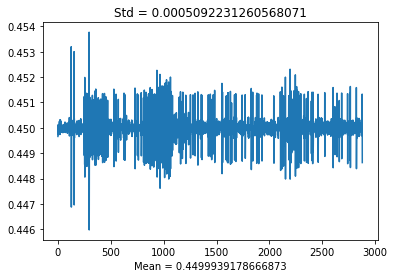

In [10]:
plt.plot(timing_list[1:])
plt.title('Std = %s' % np.std(timing_list[1:]))
plt.xlabel('Mean = %s' %np.mean(timing_list[1:]))
plt.savefig(mc.figpath+'/times.png', format = 'png')

In [11]:
rng_42_list = [0.7853981633974483, 2.617993877991494, 1.5707963267948966, 0.2617993877991494, 0.2617993877991494, 1.832595714594046, 1.308996938995747, 0.5235987755982988, 1.5707963267948966, 1.5707963267948966, 1.308996938995747, 2.356194490192345, 2.0943951023931953, 0.2617993877991494, 1.832595714594046]


In [12]:
verif_list

[0.7853981633974483,
 2.617993877991494,
 1.5707963267948966,
 0.2617993877991494,
 0.2617993877991494,
 1.832595714594046,
 1.308996938995747,
 0.5235987755982988,
 1.5707963267948966,
 1.5707963267948966,
 1.308996938995747,
 2.356194490192345,
 2.0943951023931953,
 0.2617993877991494,
 1.832595714594046]

In [13]:
verif_list == rng_42_list

True

In [14]:
%notebook -e notebook.ipynb
shutil.move('notebook.ipynb', mc.figpath+'/notebook.ipynb')


'./stimV2/AM001_07072020/notebook.ipynb'